In [124]:
import glob
import os
from sklearn.metrics import plot_confusion_matrix
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('darkgrid')
%matplotlib inline

In [125]:
# data prep and model-tuning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from sklearn.metrics import (make_scorer, cohen_kappa_score, 
                             precision_recall_curve, confusion_matrix, 
                             plot_precision_recall_curve, precision_score, 
                             recall_score, f1_score)

# types of models we'll fit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# for saving things
import pickle
# skopt generates warnings if the same parameter set is sampled again
import warnings

In [126]:
from src.models.ordinal_classifiers import (RandomForestOrdinalClassifier, 
                                            LogisticRegressionOrdinalClassifier, 
                                            SVMOrdinalClassifier)

In [127]:
from skopt.plots import plot_convergence
from sklearn.calibration import calibration_curve
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support

## Our Data

In [128]:
DATA = '../data/processed/satellite_annual_training.csv'
df = pd.read_csv(DATA).rename({'ELEVATION': 'elevation'}, axis=1)
# df = df.dropna()
print('{:,d} samples'.format(len(df)))
print('Columns:', df.columns.values)

31,599 samples
Columns: ['uuid' 'year' 'FVS_TPA' 'FVS_BA' 'FVS_SDI' 'FVS_CCF' 'FVS_QMD'
 'FVS_TCUFT' 'FVS_TOPHT' 'FVS_NUMBER_OF_STRATA' 'FVS_TOTAL_COVER'
 'FVS_STRUCTURE_CLASS' 'FVS_CANOPY_BASEHEIGHT' 'FVS_CANOPY_BULKDENSITY'
 'FVS_ABOVEGROUND_BIOMASS' 'FVS_ABOVEGROUND_CARBON' 'FVS_GS_TPA' 'FVS_AF'
 'FVS_AS' 'FVS_BM' 'FVS_BO' 'FVS_CH' 'FVS_CW' 'FVS_DF' 'FVS_DG' 'FVS_ES'
 'FVS_GC' 'FVS_GF' 'FVS_IC' 'FVS_JP' 'FVS_KP' 'FVS_LO' 'FVS_LP' 'FVS_MA'
 'FVS_MC' 'FVS_MH' 'FVS_NF' 'FVS_OH' 'FVS_OS' 'FVS_OT' 'FVS_PC' 'FVS_PL'
 'FVS_PP' 'FVS_PY' 'FVS_RA' 'FVS_RC' 'FVS_RF' 'FVS_SF' 'FVS_SH' 'FVS_SP'
 'FVS_SS' 'FVS_TO' 'FVS_WA' 'FVS_WB' 'FVS_WF' 'FVS_WH' 'FVS_WI' 'FVS_WJ'
 'FVS_WL' 'FVS_WO' 'FVS_WP' 'FVS_YC' 'FVS_TRUE_FIR' 'FVS_OTHER_HARDWOOD'
 'FVS_MAPLE' 'FVS_OAK' 'FVS_DOUGLAS_FIR' 'FVS_SPRUCE' 'FVS_CEDAR'
 'FVS_PONDEROSA_PINE' 'FVS_OTHER_SOFTWOOD' 'FVS_LODGEPOLE_PINE'
 'FVS_HEMLOCK' 'FVS_RED_ALDER' 'FVS_TANOAK' 'FVS_JUNIPER' 'FVS_LARCH'
 'S1_VV_LEAFOFF' 'S1_VH_LEAFOFF' 'S1_VV_LEAFON' 'S1_VH_LEAFON'

In [129]:
LIDAR_OUTLIERS = '../data/interim/outlier_uuids.csv'
outliers = pd.read_csv(LIDAR_OUTLIERS)
outliers['outlier_uuid'] = outliers['outlier_uuid'].str[0:8]
outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   outlier_uuid  258 non-null    object
dtypes: object(1)
memory usage: 2.1+ KB


In [130]:
df = df.loc[~df.uuid.isin(outliers.outlier_uuid)]
df['year_diff'] = (df['year'] - df['meas_yr']).astype(int)
df = df.loc[~np.logical_or(df.year_diff > df.LT_YSD_SWIR1, df.year_diff > df.LT_YSD_NBR)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28046 entries, 0 to 31598
Columns: 140 entries, uuid to year_diff
dtypes: float64(51), int64(83), object(6)
memory usage: 30.2+ MB


In [131]:
# calculate  few additional indices for sentinel-2 and landsat
for season in ['LEAFON', 'LEAFOFF']:
    for sensor in ['L8', 'S2']:
        R, G, B = f'{sensor}_R_{season}', f'{sensor}_G_{season}', f'{sensor}_B_{season}'
        NIR, SWIR1, SWIR2 =  f'{sensor}_NIR_{season}', f'{sensor}_SWIR1_{season}', f'{sensor}_SWIR2_{season}'

        NDVI = f'{sensor}_NDVI_{season}'
        df[NDVI] = (df[NIR] - df[R])/(df[NIR] + df[R])

        ENDVI = f'{sensor}_ENDVI_{season}'
        df[NDVI] = (df[NIR] + df[G] - 2*df[B])/(df[NIR] + df[G] + 2*df[B])

        SAVI = f'{sensor}_SAVI_{season}'
        df[SAVI] = 1.5*(df[NIR] - df[R])/(df[NIR] + df[R] + 0.5)
        
        BRIGHTNESS = f'{sensor}_BRIGHTNESS_{season}'
        df[BRIGHTNESS] = 0.3029*df[B] + 0.2786*df[G] + 0.4733*df[R] + 0.5599*df[NIR] + 0.508*df[SWIR1] + 0.1872*df[SWIR2]
        
        GREENNESS = f'{sensor}_GREENNESS_{season}'
        df[GREENNESS] = -0.2941*df[B] + -0.243*df[G] + -0.5424*df[R] + 0.7276*df[NIR] + 0.0713*df[SWIR1] + -0.1608*df[SWIR2]
        
        WETNESS = f'{sensor}_WETNESS_{season}'
        df[WETNESS] = 0.1511*df[B] + 0.1973*df[G] + 0.3283*df[R] + 0.3407*df[NIR] + -0.7117*df[SWIR1] + -0.4559*df[SWIR2]

In [132]:
for sensor in ['L8', 'S2']:
    bands = np.unique([col.split(f'{sensor}_')[1].split('_')[0] for col in df.columns if col.startswith(sensor)])
    for band in bands:
        col = f'{sensor}_d{band}'
        df[col] = df[f'{sensor}_{band}_LEAFON'] - df[f'{sensor}_{band}_LEAFOFF']

In [133]:
RANDOM_STATE = 19831207

## Selecting initial features and targets
This is the first step in determining what features we want to use, and what we want to predict. Later, we can still apply some procedures to choose a subset of these features to make simpler models.

Now we can apply this threshold to all the species-group-level basal areas for the plots to create a binary presence/absence classification for each species group on each plot. 

In [134]:
# LANDTRENDR
LT_COLS = ['LT_DUR_NBR', 'LT_DUR_SWIR1', 'LT_MAG_NBR', 'LT_MAG_SWIR1', 
           'LT_RATE_NBR', 'LT_RATE_SWIR1', 'LT_YSD_NBR', 'LT_YSD_SWIR1']
# LANDSAT
L8_COLS = [
    'L8_R_LEAFOFF', 'L8_G_LEAFOFF', 'L8_B_LEAFOFF', 
    'L8_NIR_LEAFOFF', 'L8_SWIR1_LEAFOFF', 'L8_SWIR2_LEAFOFF', 
    'L8_NDVI_LEAFOFF', 'L8_SAVI_LEAFOFF', 'L8_BRIGHTNESS_LEAFOFF', 'L8_GREENNESS_LEAFOFF', 'L8_WETNESS_LEAFOFF',
    'L8_R_LEAFON', 'L8_G_LEAFON', 'L8_B_LEAFON', 
    'L8_NIR_LEAFON', 'L8_SWIR1_LEAFON', 'L8_SWIR2_LEAFON',
    'L8_NDVI_LEAFON', 'L8_SAVI_LEAFON', 'L8_BRIGHTNESS_LEAFON', 'L8_GREENNESS_LEAFON', 'L8_WETNESS_LEAFON',
    'L8_dR', 'L8_dG', 'L8_dB', 
    'L8_dNIR', 'L8_dSWIR1', 'L8_dSWIR2',
    'L8_dNDVI', 'L8_dSAVI', 'L8_dBRIGHTNESS', 'L8_dGREENNESS', 'L8_dWETNESS'
]
# SENTINEL-1
S1_COLS = [
    'S1_VV_LEAFOFF', 'S1_VH_LEAFOFF', 
    'S1_VV_LEAFON', 'S1_VH_LEAFON'
]
# SENTINEL-2
S2_COLS = [
    'S2_R_LEAFOFF', 'S2_G_LEAFOFF', 'S2_B_LEAFOFF', 
    'S2_NIR_LEAFOFF', 'S2_SWIR1_LEAFOFF', 'S2_SWIR2_LEAFOFF', 
    'S2_RE1_LEAFOFF', 'S2_RE2_LEAFOFF', 'S2_RE3_LEAFOFF', 'S2_RE4_LEAFOFF', 
    'S2_NDVI_LEAFOFF', 'S2_SAVI_LEAFOFF', 'S2_BRIGHTNESS_LEAFOFF', 'S2_GREENNESS_LEAFOFF', 'S2_WETNESS_LEAFOFF',
    'S2_R_LEAFON', 'S2_G_LEAFON', 'S2_B_LEAFON', 
    'S2_NIR_LEAFON', 'S2_SWIR1_LEAFON', 'S2_SWIR2_LEAFON', 
    'S2_RE1_LEAFON', 'S2_RE2_LEAFON', 'S2_RE3_LEAFON', 'S2_RE4_LEAFON',
    'S2_NDVI_LEAFON', 'S2_SAVI_LEAFON', 'S2_BRIGHTNESS_LEAFON', 'S2_GREENNESS_LEAFON', 'S2_WETNESS_LEAFON',
    'S2_dR', 'S2_dG', 'S2_dB', 
    'S2_dNIR', 'S2_dSWIR1', 'S2_dSWIR2', 
    'S2_dRE1', 'S2_dRE2', 'S2_dRE3', 'S2_dRE4',
    'S2_dNDVI', 'S2_dSAVI', 'S2_dBRIGHTNESS', 'S2_dGREENNESS', 'S2_dWETNESS',
]
# PALSAR
P_COLS = ['P_HH', 'P_HV']


AGENCY_COLS = ['agency_BLM', 'agency_USFS', 'agency_WADNR']

# ECOREGIONS = [col for col in df.columns if col.startswith('eco_')]

In [135]:
df.columns = [x.replace('FVS_', '') for x in df.columns]

In [136]:
BA_COLS = ['TRUE_FIR', 'OTHER_HARDWOOD', 'MAPLE', 'OAK', 'DOUGLAS_FIR', 
           'SPRUCE', 'CEDAR', 'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 
           'LODGEPOLE_PINE', 'HEMLOCK', 'RED_ALDER', 'TANOAK', 'JUNIPER',
           'LARCH']

pres_cols = [x + '_pres' for x in BA_COLS]
spp_presence = (df[BA_COLS].values.reshape(-1,1) > 0).reshape(df[BA_COLS].shape)*1
spp_presence = pd.DataFrame(data=spp_presence, columns=pres_cols)

We'll use the following classification of abundance for each species:

| label | description | basal area |  
| :--: | :--: | :--: |
| 0 | absent | 0% |  
| 1 | present | (0-33%] |  
| 2 | abundant | (33-66%] |
| 3 | dominant | (66-100%] |

In [137]:
ba_prop = df[BA_COLS].divide(df[BA_COLS].sum(axis=1) + 1e-9, axis=0)
prop_cols = [x + '_prop' for x in BA_COLS]
ba_prop.columns = prop_cols

SW_SPP = ['TRUE_FIR', 'DOUGLAS_FIR', 'SPRUCE', 'CEDAR', 
          'PONDEROSA_PINE', 'OTHER_SOFTWOOD', 'LODGEPOLE_PINE', 
          'HEMLOCK', 'JUNIPER', 'LARCH']
SW_PROP_COLS = [spp+'_prop' for spp in SW_SPP]
HW_SPP = ['OTHER_HARDWOOD','MAPLE', 'OAK', 'RED_ALDER', 'TANOAK']
HW_PROP_COLS = [spp+'_prop' for spp in HW_SPP]

ba_prop['ALL_HARDWOOD_prop'] = ba_prop[HW_PROP_COLS].sum(axis=1)
ba_prop['ALL_SOFTWOOD_prop'] = ba_prop[SW_PROP_COLS].sum(axis=1)
# prop_cols.extend(['ALL_HARDWOOD_prop', 'ALL_SOFTWOOD_prop'])

abund_cols = [x + '_abund' for x in BA_COLS]
# abund_cols.extend(['ALL_HARDWOOD_abund', 'ALL_SOFTWOOD_abund'])

spp_abund = pd.DataFrame(data=np.digitize(ba_prop[prop_cols].values, [0,1/3,2/3], right=True), 
                         index=ba_prop.index,
                         columns=abund_cols)

In [138]:
spp_abund['HARDWOOD_SOFTWOOD_abund'] = np.nan

# hardwood dominance, no softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] > 0.66) & 
              (ba_prop['ALL_SOFTWOOD_prop'] < 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = -2

# hardwood dominance, softwood presence
spp_abund.loc[(ba_prop['ALL_HARDWOOD_prop'] > 0.66) & 
              (ba_prop['ALL_SOFTWOOD_prop'] >= 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = -1

# no basal area recorded, nonstocked
spp_abund.loc[np.isclose(ba_prop['ALL_HARDWOOD_prop'],0) & 
              np.isclose(ba_prop['ALL_SOFTWOOD_prop'],0),
              'HARDWOOD_SOFTWOOD_abund'] = -9998

# softwood dominance, hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] > 0.66) & 
              (ba_prop['ALL_HARDWOOD_prop'] >= 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = 1

# softwood dominance, no hardwood presence
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] > 0.66) & 
              (ba_prop['ALL_HARDWOOD_prop'] < 0.05),
              'HARDWOOD_SOFTWOOD_abund'] = 2

# softwood and hardwood equal at 40-50%
spp_abund.loc[(ba_prop['ALL_SOFTWOOD_prop'] > 0.33)&
              (ba_prop['ALL_HARDWOOD_prop'] > 0.33)& 
              (ba_prop['ALL_SOFTWOOD_prop'] > 0),
              'HARDWOOD_SOFTWOOD_abund'] = 0

spp_abund['HARDWOOD_SOFTWOOD_abund'] = spp_abund['HARDWOOD_SOFTWOOD_abund'].astype(int)

In [139]:
spp_df = pd.concat([ba_prop, spp_abund], axis=1)
spp_df.head()

,TRUE_FIR_prop,OTHER_HARDWOOD_prop,MAPLE_prop,OAK_prop,DOUGLAS_FIR_prop,SPRUCE_prop,CEDAR_prop,PONDEROSA_PINE_prop,OTHER_SOFTWOOD_prop,LODGEPOLE_PINE_prop,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,0.0,0.0,0.0,0.0,0.171717,0.0,0.0,0.828283,0.0,0.0,...,0,3,0,0,0,0,0,0,0,2
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0,3,0,0,0,0,0,0,0,2
2,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-9998
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,3,0,0,-2


In [140]:
# merge these presence and abundance classes into the dataframe
df = pd.concat([df, spp_df], axis=1)
df.head()

,uuid,year,TPA,BA,SDI,CCF,QMD,TCUFT,TOPHT,NUMBER_OF_STRATA,...,CEDAR_abund,PONDEROSA_PINE_abund,OTHER_SOFTWOOD_abund,LODGEPOLE_PINE_abund,HEMLOCK_abund,RED_ALDER_abund,TANOAK_abund,JUNIPER_abund,LARCH_abund,HARDWOOD_SOFTWOOD_abund
0,174f5abb,2018,199,100,186,100,9.581292,2113,58,1,...,0,3,0,0,0,0,0,0,0,2
1,3ca58372,2016,12,22,31,16,18.232113,846,55,1,...,0,3,0,0,0,0,0,0,0,2
2,7bd6ffce,2017,445,62,149,125,5.053601,801,39,2,...,0,0,0,0,0,0,0,0,0,2
3,cd3731de,2020,0,0,0,0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,-9998
5,1ee9b438,2016,308,219,352,305,11.410089,8212,86,2,...,0,0,0,0,0,0,3,0,0,-2


In [141]:
abund_cols

['TRUE_FIR_abund',
 'OTHER_HARDWOOD_abund',
 'MAPLE_abund',
 'OAK_abund',
 'DOUGLAS_FIR_abund',
 'SPRUCE_abund',
 'CEDAR_abund',
 'PONDEROSA_PINE_abund',
 'OTHER_SOFTWOOD_abund',
 'LODGEPOLE_PINE_abund',
 'HEMLOCK_abund',
 'RED_ALDER_abund',
 'TANOAK_abund',
 'JUNIPER_abund',
 'LARCH_abund']

In [142]:
# mark plots with canopy cover < 10%, QMD < 1", and TOPHT < 10' as non-stocked, let's not predict on them
df.loc[(df.TOTAL_COVER < 10), 'HARDWOOD_SOFTWOOD_abund'] = -9998
df.loc[(df.QMD < 1), 'HARDWOOD_SOFTWOOD_abund'] = -9998
df.loc[(df.TOPHT < 10), 'HARDWOOD_SOFTWOOD_abund'] = -9998
df = df.loc[df.HARDWOOD_SOFTWOOD_abund > -9998]
df['HARDWOOD_SOFTWOOD_abund'] =  df['HARDWOOD_SOFTWOOD_abund'] + 2

In [143]:
# plots with < 10% canopy cover, <1" QMD

In [144]:
X_COLS = ['TOTAL_COVER', 'TOPHT', 'QMD', 'TCUFT'] + S2_COLS + LT_COLS + ['elevation', 'lat', 'lon']

In [145]:
df = df.dropna(subset=X_COLS+abund_cols).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Columns: 219 entries, uuid to HARDWOOD_SOFTWOOD_abund
dtypes: float64(114), int64(99), object(6)
memory usage: 10.9+ MB


## Split the data into training and testing sets
Since some plot_ids have multiple observations, we want all observations for each plot_id to fall entirely in train_set or entirely the training or testing sets because these samples are definitely not independent.

In [146]:
# create training and testing sets for each species group
train_sets = []
test_sets = []

# make sure each plot (uuid) only goes into either train or testing set
uuids = pd.unique(df['uuid'].values)
np.random.seed(RANDOM_STATE)
train0_test1 = np.random.choice((0,1), uuids.shape, p=(0.8,0.2))
train_test_assign = pd.DataFrame(np.dstack((uuids, train0_test1))[0], columns=['uuid', 'train0_test1'])
df_assigned = df.merge(train_test_assign, on='uuid')
    
train = df_assigned.loc[df_assigned['train0_test1'] == 0]
test = df_assigned.loc[df_assigned['train0_test1'] == 1]

## Standardize features
Scale all predictive features to have 0 mean and unit variance (subtracting mean, dividing by standard deviation).

In [147]:
os.makedirs('../models/composition_models', exist_ok=True)

In [148]:
X_train, X_test = train[X_COLS].copy(), test[X_COLS].copy()
Y_train, Y_test = train[spp_df.columns], test[spp_df.columns]

# Quick Look at Data
Be aware that the data are heavily skewed towards particularly widespread species like Douglas-fir, western hemlock, and red alder. There are far fewer examples, particularly of plots with other species where those species are abundant.

In [149]:
counts = df[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,"1,591","1,030","1,194","2,685"
HEMLOCK,"3,620","1,714",681,485
TRUE_FIR,"4,951",960,333,256
RED_ALDER,"4,959","1,085",235,221
CEDAR,"5,013","1,176",239,72
OTHER_HARDWOOD,"5,078","1,187",139,96
PONDEROSA_PINE,"5,693",306,192,309
MAPLE,"5,904",554,31,11
SPRUCE,"6,079",297,79,45
OTHER_SOFTWOOD,"6,163",320,7,10


In [150]:
counts = test[abund_cols].apply(np.bincount, axis=0, minlength=4)
counts.columns = [col.split('_abund')[0] for col in counts.columns]
counts = counts.rename({0: 'absent', 1:'present', 2:'abundant', 3:'dominant'}, axis=0)
counts.T.sort_values(by='absent')\
.style.format('{:,d}')

,absent,present,abundant,dominant
DOUGLAS_FIR,339,185,261,548
HEMLOCK,729,360,138,106
RED_ALDER,991,245,58,39
TRUE_FIR,"1,030",180,66,57
CEDAR,"1,031",226,62,14
OTHER_HARDWOOD,"1,061",225,25,22
PONDEROSA_PINE,"1,161",59,44,69
MAPLE,"1,201",124,6,2
SPRUCE,"1,269",50,8,6
OTHER_SOFTWOOD,"1,272",58,3,0


In [151]:
df.groupby(by=['HARDWOOD_SOFTWOOD_abund'])['uuid'].count()

HARDWOOD_SOFTWOOD_abund
0     211
1     187
2     446
3    1333
4    4323
Name: uuid, dtype: int64

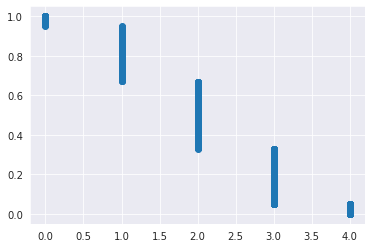

In [152]:
plt.scatter(df.HARDWOOD_SOFTWOOD_abund, df.ALL_HARDWOOD_prop)

## Fit some models

In [153]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import CheckpointSaver
from skopt import dump, load

In [154]:
# borrowed directly from Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

np.seterr(divide='ignore', invalid='ignore')
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [155]:
MODEL_SEARCH_SPACES = {
    'rf': {
        'n_estimators': Integer(50, 5000, prior='log-uniform'),
        'max_depth': Integer(2, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
        'class_weight': Categorical(['balanced', None])
    },
    'rf_ord': {
        'n_estimators': Integer(50, 1000, prior='log-uniform'),
        'max_depth': Integer(2, 32, prior='log-uniform'),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'min_samples_split': Integer(2, 20, prior='uniform'),
        'min_samples_leaf': Integer(1, 20, prior='uniform'),
        'class_weight': Categorical(['balanced', None])
    },
    'log': {
        'penalty': Categorical(['l1', 'l2', 'elasticnet', 'none']),
        'class_weight': Categorical(['balanced', None]),
        'multi_class': Categorical(['ovr', 'multinomial']),
        'C': Real(1e-4, 1e4, prior='log-uniform'),
        'l1_ratio': Real(0, 1, prior='uniform'),
    },
    'log_ord': {
        'penalty': Categorical(['l1', 'l2', 'elasticnet', 'none']),
        'class_weight': Categorical(['balanced', None]),
        'C': Real(1e-4, 1e4, prior='log-uniform'),
        'l1_ratio': Real(0, 1, prior='uniform'),
    },
    'svc':{
        'C': Real(1e-3, 1e2, prior='log-uniform'),
        'gamma': Real(1e-3, 1, prior='log-uniform'),
        'class_weight': Categorical(['balanced', None])
    },
    'svc_ord':{
        'C': Real(1e-3, 1e2, prior='log-uniform'),
        'gamma': Real(1e-3, 1, prior='log-uniform'),
        'class_weight': Categorical(['balanced', None])
    },
    'kde':{
        'bandwidth': Real(1e-3, 1e3, prior='log-uniform'),
        'kernel': Categorical(['gaussian', 'tophat', 'epanechnikov', 
                               'exponential', 'linear', 'cosine']),
    },
    'knn': {
        'n_neighbors': Integer(1, 25, prior='uniform'),
        'weights': Categorical(['uniform', 'distance']), 
        'p': Integer(1, 100, prior='log-uniform')
    },
}

MODEL_TYPES = {
    'rf': RandomForestClassifier(random_state=RANDOM_STATE,
                                 n_jobs=-1),
    'rf_ord': RandomForestOrdinalClassifier(random_state=RANDOM_STATE,
                             n_jobs=-1),
    'log': LogisticRegression(random_state=RANDOM_STATE,
                              solver='saga',
                              max_iter=1e6,
                              n_jobs=-1),
    'log_ord': LogisticRegressionOrdinalClassifier(random_state=RANDOM_STATE,
                          solver='saga',
                          max_iter=1e6,                  
                          n_jobs=-1),
    'svc': SVC(random_state=RANDOM_STATE,
               kernel='rbf'),
    'svc_ord': SVC(random_state=RANDOM_STATE,
                   kernel='rbf'),
    'kde': KDEClassifier(),
    'knn': KNeighborsClassifier(n_jobs=-1)
}

In [180]:
groupkfold = GroupKFold(n_splits=3)
uuid_groups = df.reindex(X_train.index)['uuid']
from sklearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, average_precision_score

# scorer = make_scorer(geometric_mean_score) 
# scorer = make_scorer(cohen_kappa_score, weights='linear')

def cohen_kappa_adjust(y_true, y_pred, labels=None, weights=None, sample_weight=None):
    if y_pred.dtype == 'float' and y_pred.max() <= 1.0: # regression model trained on proportions
        y_true = np.digitize(y_true, [0,1/3,2/3], right=True)
        y_pred = np.digitize(y_pred, [0,1/3,2/3], right=True)
    
    elif y_pred.dtype == 'float' and y_pred.max() > 1.0: # regression model trained on abundance integers
        y_true = y_true.round().astype(int)
        y_pred = y_pred.round().astype(int)
        
    return cohen_kappa_score(y_true, y_pred, labels=labels, weights=weights, sample_weight=sample_weight)



def tune_classifier(sp_name, model_type, samples_per_param=100, n_jobs=1, n_points=1):
    if model_type[-4:] == '_reg':
        y_train = Y_train[sp_name+'_prop']
    else:
        y_train = Y_train[sp_name+'_abund']
    
    model = MODEL_TYPES[model_type]
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model)
    ])
    search_space = MODEL_SEARCH_SPACES[model_type]
    search_space = {f'model__{key}': search_space[key] for key in search_space}
    
    if sp_name == 'HARDWOOD_SOFTWOOD':
        LABELS = [0, 1, 2, 3, 4]
    else:
        LABELS = [0, 1, 2, 3]
    
    scorer = make_scorer(cohen_kappa_adjust, labels=LABELS, weights='quadratic')
    
    opt = BayesSearchCV(
        pipe,
        search_space,
        n_iter=samples_per_param,
        random_state=RANDOM_STATE,
        cv=groupkfold,
        scoring=scorer,
        verbose=0,
        n_jobs=n_jobs,
        n_points=n_points,
    )
    
    def on_step(result):
        num_rounds = len(result.func_vals)
        if num_rounds % 10 == 1:
            print('\n@ sample iteration {}'.format(num_rounds), flush=True)

        score = result.fun
        best_score = result.func_vals[-1]

        if score == best_score:
            print('','{:0.3f}'.format(score), end=' ', flush=True)
        else:
            print('.', end='', flush=True)

    
    SAVE_DIR = '../models/composition_models'
    check_pkl = '{}_{}_tuned_checkpoints.pkl'.format(sp_name, model_type)
    check_path = os.path.join(SAVE_DIR, check_pkl)
    checkpoint_saver = CheckpointSaver(check_path)

    print('Running {:,d} rounds of cross-validation.'.format(opt.total_iterations))
    print('Sampling {} parameters {} times each.'.format(len(search_space), samples_per_param))
    print('Displaying best cross-validation scores... ')
    
    with warnings.catch_warnings():  # don't issue warnings when we test the same parameter values
        warnings.filterwarnings("ignore", 
                                category=UserWarning) 
        
        # executes bayesian optimization
        _ = opt.fit(X_train, y_train, 
                    groups=uuid_groups, 
                    callback=[on_step, checkpoint_saver])
    
    opt_pkl = '{}_{}_tuned.pkl'.format(sp_name, model_type)
    opt_path = os.path.join(SAVE_DIR, opt_pkl)
    dump(opt, opt_path)
    print('Done. \nModel saved at {}\n'.format(opt_path))
    
    return opt

In [ ]:
def print_classification_report(sp_name, model, 
                                target_names=['absent', 'present', 'abundant', 'dominant']):
    print(classification_report_imbalanced(
        Y_test[sp_name+'_abund'],
        model.predict(X_test),
        target_names=target_names))

To help interpret classification reports:
* `tp` is the number of true positives
* `fp` is the number of false positives, 
* `tn` is the number of true negatives 
* `fn` is the number of false negatives

**precision** is the ratio `tp / (tp + fp)`, or **the ability of the classifier not to label as positive a sample that is negative.** 

**recall** is the ratio `tp / (tp + fn)`, or **the ability of the classifier to find all the positive samples.**

**specificity** is the ratio `tn / (tn + fp)`, or **the ability of the classifier to find all the negative samples.**

In [ ]:
def display_confusion(sp_name, model, 
                      labels=[0, 1, 2, 3],
                      display_labels=['Absent', 'Present', 'Abundant', 'Dominant']):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          normalize='true',
                          display_labels=display_labels,
                          include_values=True,
                          values_format='.1%',
                          cmap='Greens', ax=axs[0])
    
    plot_confusion_matrix(model, 
                          X_test, 
                          Y_test[sp_name+'_abund'],
                          labels=labels,
                          display_labels=display_labels,
                          include_values=True,
                          values_format=',d',
                          cmap='Greens', ax=axs[1])
    axs[0].grid(False)
    axs[1].grid(False)
    plt.show();

In [176]:
def plot_rf_feature_importances(model):
    best_model = model.best_estimator_
    importances = best_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
                 axis=0)
    indices = np.argsort(importances)#[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(3,10))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
    plt.ylim([-1, X_train.shape[1]])
    plt.show();

In [177]:
spp_models = {spp:{} for spp in BA_COLS + ['HARDWOOD_SOFTWOOD']}

In [ ]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'rf' 

TARGET_NAMES = ['HW>>SW', 'HW>SW', 'HW~SW', 'HW<SW', 'HW<<SW']
LABELS = [0, 1, 2, 3, 4]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

test_score = cohen_kappa_score(Y_test[SP_NAME+'_abund'], 
                               spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                               labels=[0, 1, 2, 3, 4], 
                               weights='quadratic')
print('Score on Test Set: {:.3f}'.format(test_score))

plot_convergence(spp_models[SP_NAME][MOD_TYPE].optimizer_results_)

Running 150 rounds of cross-validation.
Sampling 6 parameters 25 times each.
Displaying best cross-validation scores... 

@ sample iteration 1
 -0.624  -0.671 ........
@ sample iteration 11
 -0.679 .... -0.701 .. -0.720 

In [ ]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'rf_ord' 

TARGET_NAMES = ['HW>>SW', 'HW>SW', 'HW~SW', 'HW<SW', 'HW<<SW']
LABELS = [0, 1, 2, 3, 4]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)

test_score = cohen_kappa_score(Y_test[SP_NAME+'_abund'], 
                               spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                               labels=[0, 1, 2, 3, 4], 
                               weights='quadratic')
print('Score on Test Set: {:.3f}'.format(test_score))

plot_convergence(spp_models[SP_NAME][MOD_TYPE].optimizer_results_)

In [ ]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'log' 

TARGET_NAMES = ['HW>>SW', 'HW>SW', 'HW~SW', 'HW<SW', 'HW<<SW']
LABELS = [0, 1, 2, 3, 4]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)

test_score = cohen_kappa_score(Y_test[SP_NAME+'_abund'], 
                               spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                               labels=[0, 1, 2, 3, 4], 
                               weights='quadratic')
print('Score on Test Set: {:.3f}'.format(test_score))

plot_convergence(spp_models[SP_NAME][MOD_TYPE].optimizer_results_)

In [ ]:
SP_NAME, MOD_TYPE = 'HARDWOOD_SOFTWOOD', 'log_ord' 

TARGET_NAMES = ['HW>>SW', 'HW>SW', 'HW~SW', 'HW<SW', 'HW<<SW']
LABELS = [0, 1, 2, 3, 4]
spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE], 
                           target_names=TARGET_NAMES)
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE],
                  labels=LABELS, display_labels=TARGET_NAMES)

test_score = cohen_kappa_score(Y_test[SP_NAME+'_abund'], 
                               spp_models[SP_NAME][MOD_TYPE].predict(X_test), 
                               labels=[0, 1, 2, 3, 4], 
                               weights='quadratic')
print('Score on Test Set: {:.3f}'.format(test_score))

plot_convergence(spp_models[SP_NAME][MOD_TYPE].optimizer_results_)

In [ ]:
SP_NAME, MOD_TYPE = 'DOUGLAS_FIR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'HEMLOCK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'RED_ALDER', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'CEDAR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'MAPLE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'TRUE_FIR', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'PONDEROSA_PINE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'LODGEPOLE_PINE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'OAK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'JUNIPER', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'SPRUCE', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'TANOAK', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'LARCH', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'OTHER_HARDWOOD', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])

In [ ]:
SP_NAME, MOD_TYPE = 'OTHER_SOFTWOOD', 'rf' 

spp_models[SP_NAME][MOD_TYPE] = tune_classifier(SP_NAME, MOD_TYPE, samples_per_param=25)
print_classification_report(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
display_confusion(SP_NAME, spp_models[SP_NAME][MOD_TYPE])
plot_rf_feature_importances(spp_models[SP_NAME][MOD_TYPE])